### Classification audio files with cnn1d

In [2]:
%matplotlib inline  
import gc
import pickle
import random
from multiprocessing import Pool
from scipy.io.wavfile import read, write
import numpy as np
import pandas as pd
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
import os
from numpy import random
import librosa
import numpy as np
import glob
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pydub
from random import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm

/home/nestyme/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
input_length = 16000*2

batch_size = 8

def audio_norm(data):

    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5


def load_audio_file(file_path, input_length=input_length):
    data = librosa.core.load(file_path, sr=16000)[0] 
    if len(data)>input_length:
        
        
        max_offset = len(data)-input_length
        
        offset = np.random.randint(max_offset)
        
        data = data[offset:(input_length+offset)]
        
        
    else:
        
        max_offset = input_length - len(data)
        
        offset = np.random.randint(max_offset)
        
        
        data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        
        
    data = audio_norm(data)
    return data

In [4]:
train_files = glob.glob("audio/*.wav")
#test_files = glob.glob("../input/audio_test/*.wav")
train_labels = pd.read_csv("./data.txt")
data = train_labels

In [5]:
train_labels

,Unnamed: 0,Name,Class
0,0,background_0001.wav,background
1,1,background_0001_time_stretch_0.wav,background
2,2,background_0001_time_stretch_1.wav,background
3,3,background_0001_time_stretch_10.wav,background
4,4,background_0001_time_stretch_11.wav,background
5,5,background_0001_time_stretch_12.wav,background
6,6,background_0001_time_stretch_13.wav,background
7,7,background_0001_time_stretch_2.wav,background
8,8,background_0001_time_stretch_3.wav,background
9,9,background_0001_time_stretch_4.wav,background


In [6]:
print(data.groupby('Class'))

In [7]:
train_labels.head()

,Unnamed: 0,Name,Class
0,0,background_0001.wav,background
1,1,background_0001_time_stretch_0.wav,background
2,2,background_0001_time_stretch_1.wav,background
3,3,background_0001_time_stretch_10.wav,background
4,4,background_0001_time_stretch_11.wav,background


In [8]:
Classes = train_labels['Class'].unique()

In [9]:
train_labels = train_labels.drop(["Unnamed: 0"], axis=1)

In [10]:
train_labels.head()
paths = 'audio/'+train_labels['Name']

In [11]:
paths

0                        audio/background_0001.wav
1         audio/background_0001_time_stretch_0.wav
2         audio/background_0001_time_stretch_1.wav
3        audio/background_0001_time_stretch_10.wav
4        audio/background_0001_time_stretch_11.wav
5        audio/background_0001_time_stretch_12.wav
6        audio/background_0001_time_stretch_13.wav
7         audio/background_0001_time_stretch_2.wav
8         audio/background_0001_time_stretch_3.wav
9         audio/background_0001_time_stretch_4.wav
10        audio/background_0001_time_stretch_5.wav
11        audio/background_0001_time_stretch_6.wav
12        audio/background_0001_time_stretch_7.wav
13        audio/background_0001_time_stretch_8.wav
14        audio/background_0001_time_stretch_9.wav
15                       audio/background_0002.wav
16        audio/background_0002_time_stretch_0.wav
17        audio/background_0002_time_stretch_1.wav
18       audio/background_0002_time_stretch_10.wav
19       audio/background_0002_

In [12]:
cnt_classes={'background': 1126,
 'bags': 2362,
 'door': 5778,
 'keyboard': 7003,
 'knocking_door': 8659,
 'ring': 9372,
 'speech': 9648,
 'tool': 11307}

In [13]:
train_labels['Class'][1658]

'bags'

In [14]:
train_labels.head()

,Name,Class
0,background_0001.wav,background
1,background_0001_time_stretch_0.wav,background
2,background_0001_time_stretch_1.wav,background
3,background_0001_time_stretch_10.wav,background
4,background_0001_time_stretch_11.wav,background


In [15]:
train_labels.groupby(['Class'][0])

In [16]:
file_to_label = {"audio/" + k:v for k,v in zip(train_labels.Name.values, train_labels.Class.values)}

In [17]:
train_labels['Class'][0]

'background'

In [18]:
sizes=[] 
for i in range(len(paths)):
    sizes.append(os.path.getsize(paths[i]))

In [19]:
d = {'path':paths, 'size':sizes,'Class':train_labels['Class']}
df=pd.DataFrame(data=d, columns=['path','size','Class'])

In [20]:
df.head()

,path,size,Class
0,audio/background_0001.wav,302750,background
1,audio/background_0001_time_stretch_0.wav,440562,background
2,audio/background_0001_time_stretch_1.wav,435726,background
3,audio/background_0001_time_stretch_10.wav,492048,background
4,audio/background_0001_time_stretch_11.wav,584880,background


In [21]:
df = df.sort_values(by='size',ascending=False)
df = df.reset_index()

In [22]:
df.head(100)

,index,path,size,Class
0,10009,audio/tool_0362.wav,10477228,tool
1,10010,audio/tool_0363.wav,10477228,tool
2,1339,audio/bg_0011_time_stretch_0.wav,4509400,bags
3,1343,audio/bg_0012_time_stretch_0.wav,4091322,bags
4,1341,audio/bg_0011_time_stretch_3.wav,3664552,bags
5,1344,audio/bg_0012_time_stretch_1.wav,3651772,bags
6,1469,audio/bg_0043_time_stretch_3.wav,3354028,bags
7,1473,audio/bg_0044_time_stretch_3.wav,3316010,bags
8,1468,audio/bg_0043_time_stretch_1.wav,3055368,bags
9,1467,audio/bg_0043_time_stretch_0.wav,3035804,bags


In [23]:
df=df.drop('index',axis=1)

In [24]:
train_labels['Class'][1658]

'bags'

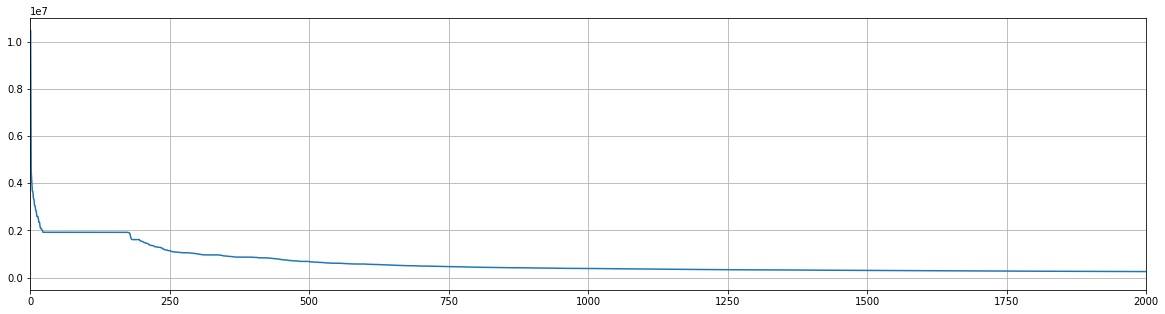

In [25]:
a = []
for i in range(len(df)):
    a.append(i)
plt.figure(figsize=(20,5))
plt.xlim(0,2000)
plt.grid()
plt.plot(a,df['size'])
plt.show()

## concate files

In [26]:
df_1=df[1:250]
df_2=df[251:2000]
df_3=df[2001::]

In [27]:
df_3.to_csv('Small.csv')
df_2.to_csv('Middle.csv')
df_1.to_csv('Large.csv')

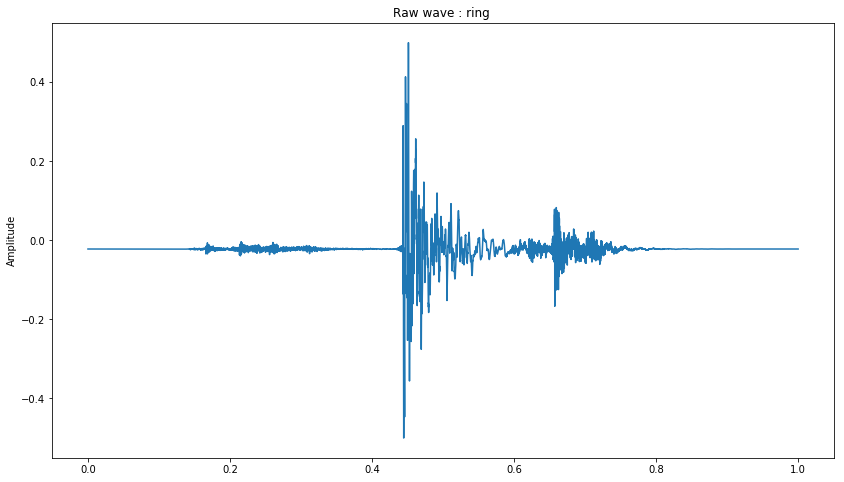

In [28]:
data_base = load_audio_file(train_files[1])
fig = plt.figure(figsize=(14, 8))
plt.title('Raw wave : %s ' % (file_to_label[train_files[0]]))
plt.ylabel('Amplitude')
plt.plot(np.linspace(0, 1, input_length), data_base)
plt.show()

In [29]:
list_labels = sorted(list(set(train_labels.Class.values)))

In [30]:
list_labels

['background',
 'bags',
 'door',
 'keyboard',
 'knocking_door',
 'ring',
 'speech',
 'tool']

In [31]:
label_to_int = {k:v for v,k in enumerate(list_labels)}

In [32]:
int_to_label = {v:k for k,v in label_to_int.items()}

In [33]:
file_to_label = {"audio/" + k:v for k,v in zip(train_labels.Name.values, train_labels.Class.values)}

In [34]:
file_to_int = {k:label_to_int[v] for k,v in file_to_label.items()}

In [35]:
def get_model():
    nclass = len(list_labels)
    inp = Input(shape=(input_length, 1))
    img_1 = Convolution1D(16, kernel_size=9, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=9, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=16)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=4)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=4)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu)(img_1)
    dense_1 = Dense(1028, activation=activations.relu)(dense_1)
    dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.0001)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model

In [36]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [37]:
def train_generator(list_files, batch_size=batch_size):
    while True:
        shuffle(list_files)
        for batch_files in chunker(list_files, size=batch_size):
            batch_data = [load_audio_file(fpath) for fpath in batch_files]
            batch_data = np.array(batch_data)[:,:,np.newaxis]
            batch_labels = [file_to_int[fpath] for fpath in batch_files]
            batch_labels = np.array(batch_labels)
            #print(batch_data)
            print(batch_data.shape)
            print('++++++++++++++++++++++++++++++++++++')
            print(batch_labels)
            yield batch_data, batch_labels
            

In [38]:
tr_files, val_files = train_test_split(train_files, test_size=0.1)

In [39]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [40]:
model = get_model()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32000, 1)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 31992, 16)         160       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 31984, 16)         2320      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1999, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1999, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1997, 32)          1568      
___________________________________________________________

In [41]:
batch_size = 32

In [42]:
model.save_weights("cnn15.h5")

In [ ]:
model.fit_generator(train_generator(tr_files), steps_per_epoch=len(tr_files)//batch_size, epochs=5,
                   use_multiprocessing=True, workers=4, max_queue_size=10)

/home/nestyme/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
(8, 32000, 1)
++++++++++++++++++++++++++++++++++++
[3 0 5 2 2 5 5 7]
(8, 32000, 1)
++++++++++++++++++++++++++++++++++++
[2 3 5 1 5 7 3 7]
(8, 32000, 1)
++++++++++++++++++++++++++++++++++++
[5 2 2 1 3 6 1 7]
(8, 32000, 1)
++++++++++++++++++++++++++++++++++++
[3 2 2 1 2 7 1 1]
(8, 32000, 1)
++++++++++++++++++++++++++++++++++++
[3 2 2 2 2 4 0 5]
(8, 32000, 1)
++++++++++++++++++++++++++++++++++++
[0 2 3 1 4 4 2 4]
(8, 32000, 1)
++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++
(8, 32000, 1)
[5 4 0 3 4 4 3 4]
[3 2 6 4 2 7 4 4]
(8, 32000, 1)
++++++++++++++++++++++++++++++++++++
[1 3 7 2 4 0 7 7]
(8, 32000, 1)
++++++++++++++++++++++++++++++++++++
[7 1 0 0 1 4 2 2]


In [43]:
list_preds = []


In [44]:
for batch_files in tqdm(chunker(val_files, size=batch_size), total=len(val_files)//batch_size ):
    batch_data = [load_audio_file(fpath) for fpath in batch_files]
    batch_data = np.array(batch_data)[:,:,np.newaxis]
    preds = model.predict(batch_data).tolist()
    list_preds += preds            

36it [02:05,  3.50s/it]                        


In [45]:
array_preds = np.array(list_preds)

In [46]:
len(list_preds)

1131

In [47]:
list_preds

[[0.12516917288303375,
  0.12484081834554672,
  0.1250198632478714,
  0.12494181096553802,
  0.12507978081703186,
  0.12495722621679306,
  0.12498976290225983,
  0.12500154972076416],
 [0.12525561451911926,
  0.12473436444997787,
  0.12504824995994568,
  0.12487305700778961,
  0.12514114379882812,
  0.12494286894798279,
  0.12502557039260864,
  0.12497908622026443],
 [0.12517234683036804,
  0.12482941895723343,
  0.12503260374069214,
  0.12492722272872925,
  0.1250915229320526,
  0.12495384365320206,
  0.12499591708183289,
  0.12499713152647018],
 [0.1252206563949585,
  0.12477581948041916,
  0.1250305324792862,
  0.12489945441484451,
  0.1250859946012497,
  0.12494586408138275,
  0.125030979514122,
  0.12501075863838196],
 [0.12521320581436157,
  0.12481947988271713,
  0.12501129508018494,
  0.12494678050279617,
  0.12507539987564087,
  0.12494157999753952,
  0.12497378140687943,
  0.1250184327363968],
 [0.1251629889011383,
  0.12480933219194412,
  0.12505896389484406,
  0.12492968887

In [48]:
list_labels = np.array(list_labels)

In [49]:
len(list_labels)

8

In [50]:
top_1 = list_labels[np.argsort(-array_preds, axis=1)[:, :1]]
pred_labels = [label_to_int[' '.join(list(x))] for x in top_1]
true_labels = [label_to_int[file_to_label[x]] for x in val_files]

In [51]:
from sklearn.metrics import roc_auc_score, f1_score, classification_report

In [52]:
list_labels

array(['background', 'bags', 'door', 'keyboard', 'knocking_door', 'ring',
       'speech', 'tool'], dtype='<U13')

In [53]:
print(classification_report(true_labels, pred_labels, target_names=list(list_labels)))

               precision    recall  f1-score   support

   background       0.10      1.00      0.19       117
         bags       0.00      0.00      0.00       123
         door       0.00      0.00      0.00       329
     keyboard       0.00      0.00      0.00       113
knocking_door       0.00      0.00      0.00       175
         ring       0.00      0.00      0.00        74
       speech       0.00      0.00      0.00        27
         tool       0.00      0.00      0.00       173

  avg / total       0.01      0.10      0.02      1131



/home/nestyme/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
f1_score(pred_labels, true_labels, average='macro')

In [ ]:
true_labels[:10]

In [ ]:
df = pd.DataFrame(test_files, columns=["fname"])
df['label'] = pred_labels

In [ ]:
df['fname'] = df.fname.apply(lambda x: x.split("/")[-1])